In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train = pd.read_csv("0415_data_4.csv", sep=",", header=None)
X1 = train.values[0:, 0:9]
X2 = train.values[0:, 12:17]
X = np.concatenate((X1,X2), axis=1)
y = train.values[0:, 18:]

X = X.astype('float64') 
y = y.astype('float64') 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).squeeze(1).long() - 1
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).squeeze(1).long() - 1

BATCH_SIZE = 10

training_dataset = TensorDataset(X_train, y_train)
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testing_dataset = TensorDataset(X_test, y_test)
testing_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=False)


Training data shape:  (246, 14)
Training labels shape:  (246, 1)
Test data shape:  (62, 14)
Test labels shape:  (62, 1)


In [ ]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    
  def forward(self, x):
    h = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h)
    y_pred = torch.nn.functional.softmax(y_pred, dim=1)
    return y_pred

In [ ]:
D_in, H, D_out = 14, 100, 4
GIVEN_E = 0.01 # 1.2 or 10

model = TwoLayerNet(D_in, H, D_out).double()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loss_list = []
train_acc_list = []

for t in range(100):

  train_loss = 0
  train_correct = 0

  for x,y in (training_dataloader):
    optimizer.zero_grad()

    y_pred = model(x)        
    loss = torch.nn.functional.cross_entropy(y_pred, y)

    train_loss += loss

    _, y_pred = torch.max(y_pred,1)
           
    train_correct += (y_pred==y).sum()
    train_correct = int(train_correct)

    if loss <= GIVEN_E:
      break
    else:
      loss.backward()
      optimizer.step()
  
  if loss <= GIVEN_E:
    print('acceptable SLFN')
    print('Train loss: ', loss.item())
    break
      
  else:
    train_loss =  train_loss / len(training_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct / len(training_dataset))
    if t % 10 == 0:
      print(f'Epoch: {t}, Train loss: ', train_loss.item(), 'acc:', train_acc_list[-1])
    if t == 99:
      print('unacceptable SLFN')
      

Epoch: 0, Train loss:  1.5261315524629493 acc: 0.15853658536585366
Epoch: 10, Train loss:  1.3000293883365517 acc: 0.532520325203252
Epoch: 20, Train loss:  1.264078824431227 acc: 0.5528455284552846
Epoch: 30, Train loss:  1.252353019281624 acc: 0.5691056910569106
Epoch: 40, Train loss:  1.2380437375581246 acc: 0.5691056910569106
Epoch: 50, Train loss:  1.2260155600216092 acc: 0.5691056910569106
Epoch: 60, Train loss:  1.2070607798885566 acc: 0.5609756097560976
Epoch: 70, Train loss:  1.1944340588704827 acc: 0.5975609756097561
Epoch: 80, Train loss:  1.1720268293065133 acc: 0.6626016260162602
Epoch: 90, Train loss:  1.1531591762425035 acc: 0.6951219512195121
unacceptable SLFN


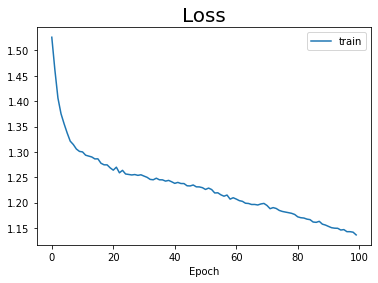

In [ ]:
plt.plot(train_loss_list, label='train')
plt.xlabel('Epoch')
plt.title('Loss',size = 20)
plt.legend()
plt.show()

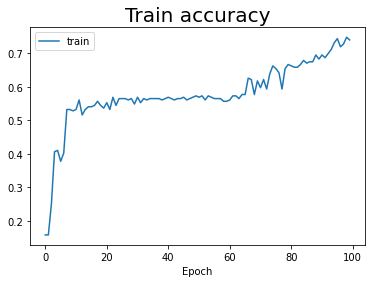

In [ ]:
plt.plot(train_acc_list, label='train')
plt.legend()
plt.xlabel('Epoch')
plt.title('Train accuracy',size = 20)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  test_loss = 0 # accumulate testing loss for each batch
  test_correct = 0

  for x, y in testing_dataloader:

    prediction = model(x) # call forward function
        
    loss = torch.nn.functional.cross_entropy(prediction, y)
    test_loss += loss

    _, prediction = torch.max(prediction,1)
        
    test_correct += (prediction==y).sum()
    test_correct = int(test_correct)

  test_loss = test_loss.item()

print("Test loss:{:.2f}, Test accuracy: {:.2f}".format(test_loss / len(testing_dataloader),test_correct / len(testing_dataset)))

Test loss:1.15, Test accuracy: 0.73
